In [294]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils as utils
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns 
import scipy 
from scipy.optimize import minimize 
from decimal import Decimal 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [296]:
seed = 4444 

Hey Kiran, so besides the transformed data, I also wrote some codes to load them either in the format of whole dataset or individually. 

In [297]:
dir_ = 'mengqi_buffer/'
# dir_ = 'new_data/transformed_buffer/'

# this will load all files in the transformed_buffer dir, with specificed min length 
# isDx = False if you want position data instead of displacement data
# track_info tells you how long each track is and track_id tells you to which actual file that track belongs to
x, y, t, track_info, lookup, track_id = utils.loadRawMinData(dir_, min_length=10, isDx=False)

Total 15 files read; Total 398 trajectories (length >= 10) loaded; Total 21295 data points


In [298]:
dx, dy, dt, track_info2, lookup, track_id = utils.loadRawMinData(dir_, min_length=10, isDx=True) 

Total 15 files read; Total 398 trajectories (length >= 10) loaded; Total 20897 data points


In [299]:
ind = 50 
sdx, sdy, sdt = utils.loadSelectTraj(dx, dy, dt, track_info2, ind, True)

First select take a look at the track that I know is going to converge using the HPW model.

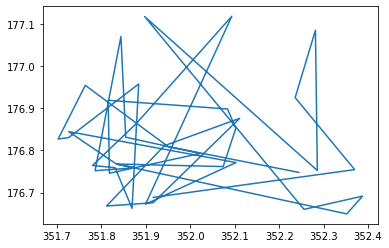

In [300]:
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, ind, False)
plt.plot(sx, sy);

In [308]:
np.allclose(np.diff(sx), sdx) 

True

## Generate fake data 

Here, we generate data from the two populations of either totally diffusive or confined to a harmonic potential well where we seek to recover these values from noisy data under the *DensityDist* MCMC implementation. 

## Brownian diffusion model 

Here, we assume that the position of a Brownian particle at the $k^{th}$ time point can be described as 

$$ x_k \mid x_{k-1}, D \sim \mathcal{N}\left(0, 2 D \tau_k \right) $$ 

where $\tau_k = t_k - t_{k-1}$ is the lag time and relating it to the main document, the displacement is given as $r_k = \vert x_k - x_{k-1} \vert$. 

#### Notes 

Our working units are $\{pix., frames\}$, both $x$ and $y$ have units of $[pix.]$, $t$ is specified in units of $[frames]$ which means $D$ is specified in units of $[pix.^2/ frame]$ which makes it $\sim \mathcal{O}(1)$. 

In [120]:
np.random.seed(seed) 
init_pos = [0., 0.]
t_ = np.linspace(0, 422, 423) 
D = 1 

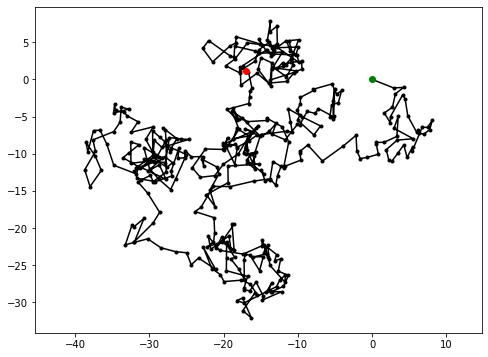

In [129]:
np.random.seed(seed) 

plt.figure(figsize=(8,6))
base = utils.base_brownian_D(init_pos, t_, D)  
traj = utils.augment_with_noise(base, Me=None) 

utils.plot_2D_trajectory(traj)

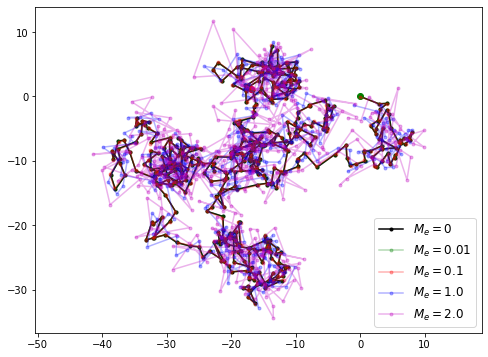

In [140]:
utils.plot_test_Me(init_pos, t_, D, Me_array=[0.01, 0.1, 1.0, 2.0])

In [151]:
np.random.seed(seed) 
init_pos = [0., 0.]
t_ = np.linspace(0, 422, 423) 
D = 1 
well_pos = [-10., 1.] 
lambda_ = np.exp(-10) 
print('The well strength of magnitude {:.2e}, while the diffusion constant is {:.1e} [pix.^2/frame].'.format(lambda_, D))

The well strength of magnitude 4.54e-05, while the diffusion constant is 1.0e+00 [pix.^2/frame].


## For weak confinement $\lambda\tau \ll 1$, the harmonic potential well should virtually undetectable 

Well strengths that are undectable are generally those below $e^{-8}$ which is $\sim \mathcal{O}(10^{-4})$ relative to $D$ of $\sim \mathcal{O}(1)$. 

In [152]:
np.random.seed(seed)
baseBD = base_brownian_D(init_pos, t_, D)   

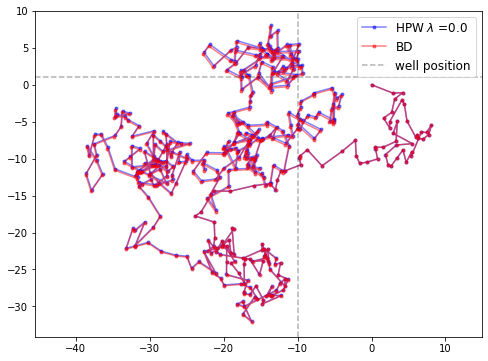

In [153]:
np.random.seed(seed)
utils.plot_test_lambda_single(init_pos, t_, D, well_pos, lambda_, baseBD)

In [154]:
np.random.seed(seed) 
init_pos = [0., 0.]
t_ = np.linspace(0, 422, 423) 
D = 1 
well_pos = [-10, 1.] 
lambda_ = np.exp(-2) 
print('The well strength of magnitude {:.2e}, while the diffusion constant is {:.1e} [pix.^2/frame].'.format(lambda_, D))

The well strength of magnitude 1.35e-01, while the diffusion constant is 1.0e+00 [pix.^2/frame].


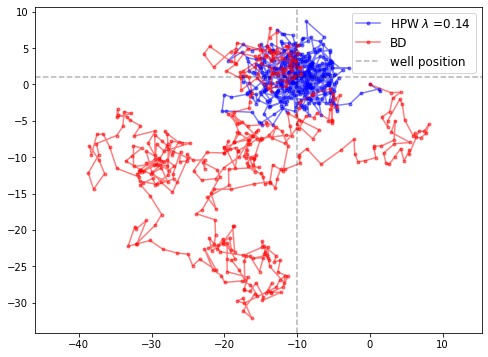

In [155]:
np.random.seed(seed)
utils.plot_test_lambda_single(init_pos, t_, D, well_pos, lambda_, baseBD)

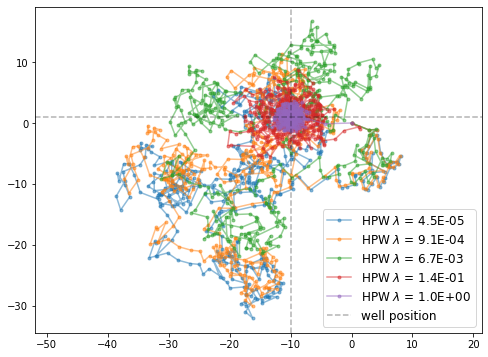

In [168]:
lambda_vis = np.array([np.exp(-10), np.exp(-7), np.exp(-5), np.exp(-2), np.exp(0)])

utils.plot_test_lambda(init_pos, t_, D, well_pos, lambda_vis)

## Priors 

Priors are normally distributed in logspace and are "weakly" informative to be representative of the parameters one would encounter in experiment. 

In [502]:
param = utils.generate_params(Jiayu_params=False) 
param 

{'mu_D': -3.0,
 'sigma_D': 2.0,
 'mu_lambda': -10.0,
 'sigma_lambda': 5.0,
 'mu_Me': -2.0,
 'sigma_Me': 0.5}

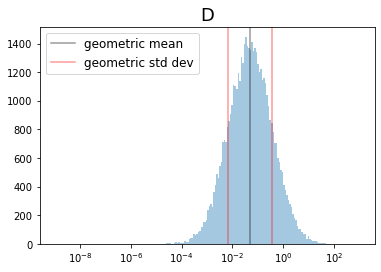

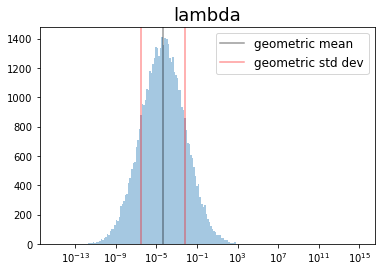

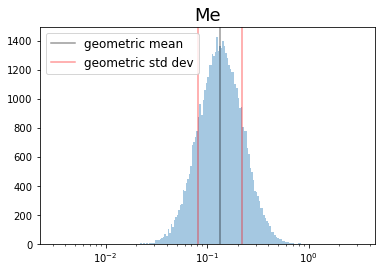

In [503]:
utils.plot_priors(param)

In [504]:
priors = [('D', pm.Lognormal.dist(mu=param['mu_D'], sd=param['sigma_D'])), 
         ('lambda', pm.Lognormal.dist(mu=param['mu_lambda'], sd=param['sigma_lambda'])), 
         ('Me', pm.Lognormal.dist(mu=param['mu_Me'], sd=param['sigma_Me']))] 

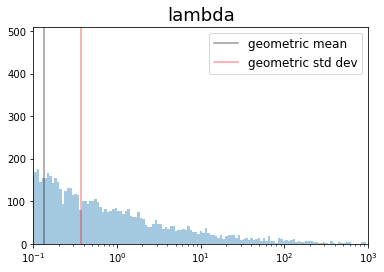

In [510]:
plt.figure() 
sns.distplot(priors[1][1].random(size=100000), bins=ranges[1], kde=False) ## count data 
#     plt.plot(ranges[i], np.exp(prior[1].logp(ranges[i]).eval()), label=str(prior[0]), lw=3) ## pdf 
plt.semilogx() 
plt.title(priors[1][0], fontsize=18)
plt.axvline(np.exp(stats[1][0]), c='k', alpha=0.4, label='geometric mean') 
plt.axvline(np.exp(stats[1][0] + stats[1][1]), c='r', alpha=0.4, label='geometric std dev') 
plt.axvline(np.exp(stats[1][0] - stats[1][1]), c='r', alpha=0.4)
plt.legend(fontsize=12)
plt.xlim(1e-1, 1e3) 
pass 

# Results without measurement noise ($M_e$)

In all cases here, the HPW will be slightly off center but of a **known** location. We will recover unknown values of the diffusion coefficient $D$, and the harmonic well potential strength $\lambda$ first in simple scenarios and then in more difficult cases. 

## Case 1: Exprerimentally relevant $D$, $\lambda$ w/ Menqi's experimental temporal resolution 

Diffusion in a harmonic potential well (HPW) with experimentally relevant values of $D$, $\lambda$ uncorrupted by measurement noise $M_e$. 

In this case, we generate the data at 12.5 frames per second which was also used in experiment. 

We have three edge cases, where the relevant distance is $\sqrt{D/lambda}$ the first case O(less than 1) which is where the data is purely measurement noise or $D$ is small and $\lambda$ is big, in this case, the jumps between time points are uncorrealted and we sample only from a normal distribution which is the HPW. We can a lot about the location of the HPW but virutally nothing about the rate parameters $D$ and $\lambda$. Case 2 is the case that we analyze below, it is O(1) where the jumps are not uncorrelated and we can learn about $D$ and $\lambda$ if our observation timescale is commensurate with this distance (?). Case 3 is where we are freely diffusing, which can be augmented with measurement noise and we can recover $D$ but say nothing about $\lambda$ other than it is small. 

In [565]:
param = utils.generate_params(Jiayu_params=False) 
param 

{'mu_D': -3.0,
 'sigma_D': 2.0,
 'mu_lambda': -10.0,
 'sigma_lambda': 5.0,
 'mu_Me': -2.0,
 'sigma_Me': 0.5}

1. D $\rightarrow$ large 
2. $\lambda$ $\rightarrow$ small 
3. low temporal resolution 

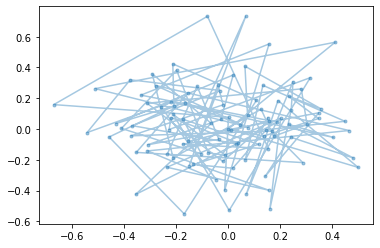

In [566]:
np.random.seed(5555)

init_pos = [0., 0.]
D_large = 0.175 # um^2/s
lambda_small = 250  #s^-1 
n_data = 101 
fps = 12.5 

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_ = np.linspace(0, n_data/fps, n_data) 
well_pos = [0., 0.]

simple_BD = [init_pos, t_, D_large, well_pos, lambda_small, None] 
traj = utils.generate_data(simple_BD) 

plt.plot(traj[0]/pixelToUm, traj[1]/pixelToUm, '.-', alpha=0.4)

D_scaled = D_large*time_step1/pixelToUm**2
lambda_scaled = lambda_small*time_step1 

sx, sy = traj 
sdt = np.diff(t_) 
sdx = np.diff(sx); sdy = np.diff(sy)

In [567]:
print('Note the shape of the dataset is of length {}.'.format(t_.shape[0])) 

Note the shape of the dataset is of length 101.


In [568]:
with pm.Model() as model:
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lamda = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda']) 
   
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-lamda*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-lamda*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*lamda*sdt))/lamda)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [582]:
with model: 
    trace1 = pm.sample(5000, tune=4000, chains=4, cores=4, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, D]
Sampling 4 chains, 0 divergences: 100%|██████████| 36000/36000 [00:44<00:00, 808.67draws/s] 
The number of effective samples is smaller than 10% for some parameters.


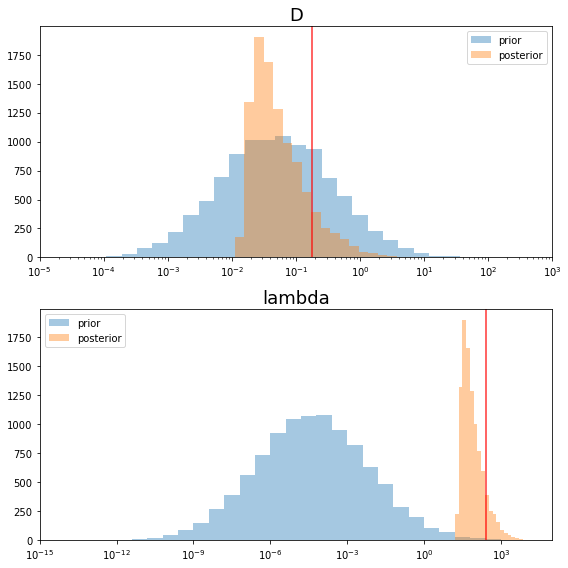

In [572]:
utils.plot_prior_posterior(param, trace1, [D_large, lambda_small]) 

### Verify that this is not a property of the HMC NUTS chain 

1. D $\rightarrow$ large 
2. $\lambda$ $\rightarrow$ small 
3. low temporal resolution 

In [587]:
np.sqrt(0.175 * np.diff(np.linspace(0, n_data/fps, n_data))[0]) 

0.11891173196955798

In [588]:
np.sqrt(0.175/250)

0.026457513110645904

## this is representative of a very confined particle, with no/ little correlation between time steps 

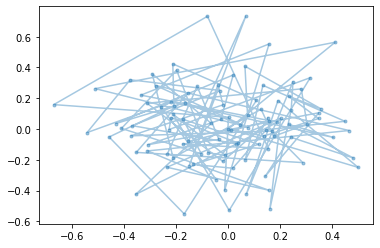

In [573]:
np.random.seed(5555)

init_pos = [0., 0.]
D_large = 0.175 # um^2/s
lambda_small = 250  #s^-1 
n_data = 101 
fps = 12.5 

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_ = np.linspace(0, n_data/fps, n_data) 
well_pos = [0., 0.]

simple_BD = [init_pos, t_, D_large, well_pos, lambda_small, None] 
traj = utils.generate_data(simple_BD) 

plt.plot(traj[0]/pixelToUm, traj[1]/pixelToUm, '.-', alpha=0.4)

D_scaled = D_large*time_step1/pixelToUm**2
lambda_scaled = lambda_small*time_step1 

sx, sy = traj 
sdt = np.diff(t_) 
sdx = np.diff(sx); sdy = np.diff(sy)

In [574]:
print('Note the shape of the dataset is of length {}.'.format(t_.shape[0])) 

Note the shape of the dataset is of length 101.


In [575]:
with pm.Model() as model:
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lamda = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda']) 
   
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-lamda*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-lamda*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*lamda*sdt))/lamda)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [576]:
with model: 
    trace1 = pm.sample(10000, tune=10000, chains=2, cores=1, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, D]
Sampling chain 1, 0 divergences: 100%|██████████| 20000/20000 [01:18<00:00, 254.94it/s]
The number of effective samples is smaller than 10% for some parameters.


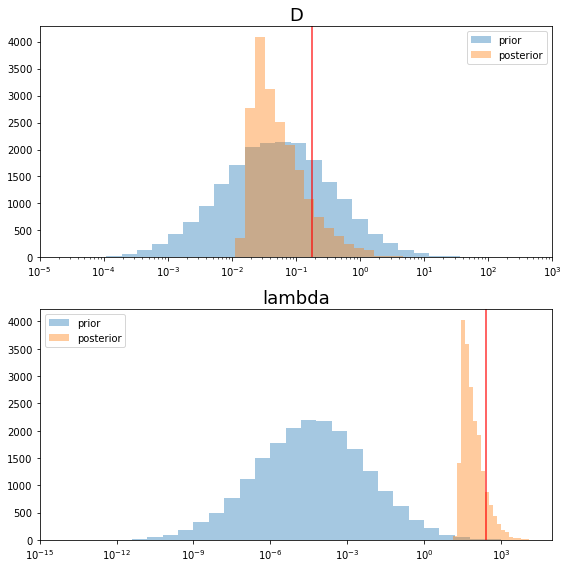

In [577]:
utils.plot_prior_posterior(param, trace1, [D_large, lambda_small]) 

### Verify that this is not solved by using SMC sampling 

In [583]:
with model: 
    traceSMC = pm.sample_smc(draws=20000, cores=6, tune_steps=True, parallel=True)

Sample initial stage: ...
Stage:   0 Beta: 0.013 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.041 Steps:  25 Acce: 0.539
Stage:   2 Beta: 0.068 Steps:   5 Acce: 0.337
Stage:   3 Beta: 0.101 Steps:  11 Acce: 0.171
Stage:   4 Beta: 0.342 Steps:  24 Acce: 0.083
Stage:   5 Beta: 1.000 Steps:  25 Acce: 0.483


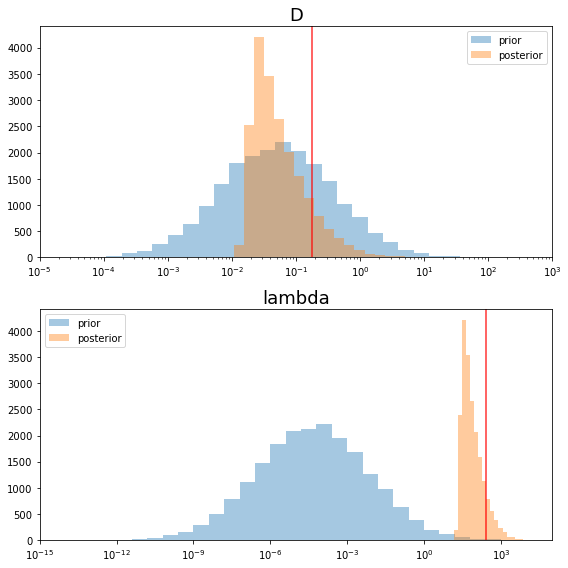

In [584]:
utils.plot_prior_posterior(param, traceSMC, [D_large, lambda_small]) 

### Verify that this is not a function of the uncertainty in the prior 

1. D $\rightarrow$ large 
2. $\lambda$ $\rightarrow$ small 
3. strongly informative prior on $\lambda$ 

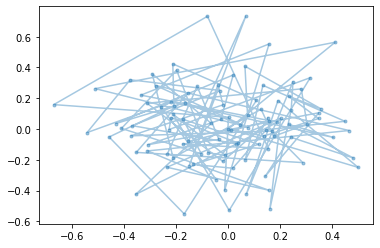

In [589]:
np.random.seed(5555)

init_pos = [0., 0.]
D_large = 0.175 # um^2/s
lambda_small = 250  #s^-1 
n_data = 101 
fps = 12.5 

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_ = np.linspace(0, n_data/fps, n_data) 
well_pos = [0., 0.]

simple_BD = [init_pos, t_, D_large, well_pos, lambda_small, None] 
traj = utils.generate_data(simple_BD) 

plt.plot(traj[0]/pixelToUm, traj[1]/pixelToUm, '.-', alpha=0.4)

D_scaled = D_large*time_step1/pixelToUm**2
lambda_scaled = lambda_small*time_step1 

sx, sy = traj 
sdt = np.diff(t_) 
sdx = np.diff(sx); sdy = np.diff(sy)

In [590]:
print('Note the shape of the dataset is of length {}.'.format(t_.shape[0])) 

Note the shape of the dataset is of length 101.


In [591]:
param['mu_lambda'] = 0.; param['sigma_lambda'] = 3. 

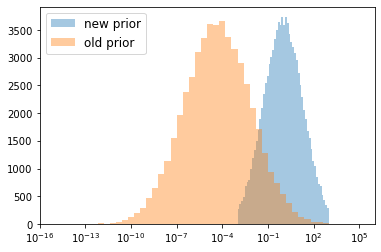

In [592]:
plt.hist(pm.Lognormal.dist(mu=param['mu_lambda'], sd=param['sigma_lambda']).random(size=100000), density=False, 
         bins = np.logspace(-3, 3, 51),
         label='new prior', alpha=0.4) 
plt.hist(pm.Lognormal.dist(mu=-10., sd=5.).random(size=50000), density=False, 
         bins = np.logspace(-10. - 1.*5., -10. + 3.*5., 51), label='old prior', alpha=0.4) 
plt.semilogx() 
plt.legend(fontsize=12) 
pass 

In [593]:
with pm.Model() as model:
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lamda = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda']) 
   
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-lamda*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-lamda*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*lamda*sdt))/lamda)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [594]:
with model: 
    trace1 = pm.sample(5000, tune=4000, chains=2, cores=1, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, D]
Sampling chain 1, 0 divergences: 100%|██████████| 9000/9000 [00:32<00:00, 275.35it/s]
The number of effective samples is smaller than 10% for some parameters.


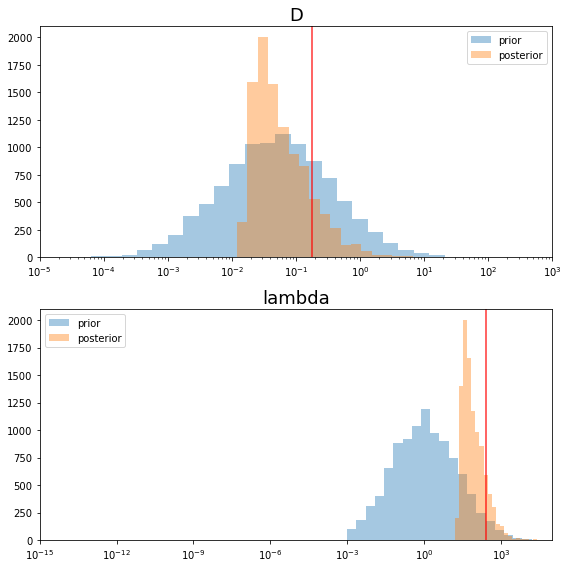

In [595]:
utils.plot_prior_posterior(param, trace1, [D_large, lambda_small]) 

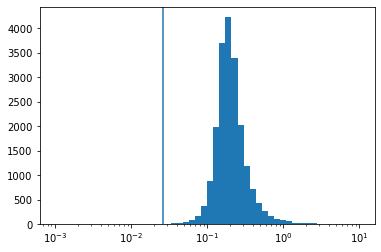

In [600]:
plt.hist(np.sqrt(trace['D']/trace['lam']), bins=np.logspace(-3, 1, 51), density=False) 
plt.axvline(np.sqrt(D_large/lambda_small)) 
plt.semilogx() 
pass 

In [601]:
np.sqrt(trace['D'].mean()/trace['lam'].mean())

0.17304106312079257

In [598]:
np.sqrt(D_large/lambda_small)

0.026457513110645904

### Validate that the time between sequential datapoints (given by $sdt$) is the variable that controls convergence of the posterior 

Two ways to do this, 
1. artifically increase the number of time points between $t_{start}$ and $t_{end}$ 
2. artifically reduce $t_{end}$ with the same number of data points 

In [549]:
## go back to the old priors 

param = utils.generate_params(Jiayu_params=False) 
param 

{'mu_D': -3.0,
 'sigma_D': 2.0,
 'mu_lambda': -10.0,
 'sigma_lambda': 5.0,
 'mu_Me': -2.0,
 'sigma_Me': 0.5}

1. D $\rightarrow$ large 
2. $\lambda$ $\rightarrow$ small 
3. high temporal resolution 

#### Artifically increasing the number of time points between $t_{start}$ and $t_{end}$ 

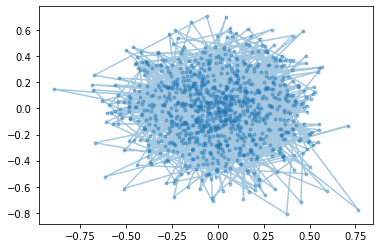

In [550]:
np.random.seed(5555)

init_pos = [0., 0.]
D_large = 0.175 # um^2/s
lambda_small = 250  #s^-1 
n_data = 101 

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_ = np.linspace(0, time_step1*(n_data-1), n_data*10) ####### NOTE HERE 
well_pos = [0., 0.]

simple_BD = [init_pos, t_, D_large, well_pos, lambda_small, None] 
traj = utils.generate_data(simple_BD) 

plt.plot(traj[0]/pixelToUm, traj[1]/pixelToUm, '.-', alpha=0.4)

D_scaled = D_large*time_step1/pixelToUm**2
lambda_scaled = lambda_small*time_step1 

sx, sy = traj 
sdt = np.diff(t_) 
sdx = np.diff(sx); sdy = np.diff(sy)

In [554]:
t_[:5], t_[-5:]

(array([0.        , 0.00792864, 0.01585728, 0.02378593, 0.03171457]),
 array([7.96828543, 7.97621407, 7.98414272, 7.99207136, 8.        ]))

In [555]:
print('Note the shape of the dataset is of length {}.'.format(t_.shape[0]))

Note the shape of the dataset is of length 1010.


In [556]:
with pm.Model() as model:
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lamda = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda']) 
   
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-lamda*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-lamda*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*lamda*sdt))/lamda)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [557]:
with model: 
    trace1 = pm.sample(5000, tune=4000, chains=2, cores=1, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, D]
Sampling chain 1, 0 divergences: 100%|██████████| 9000/9000 [00:55<00:00, 161.03it/s]
The number of effective samples is smaller than 25% for some parameters.


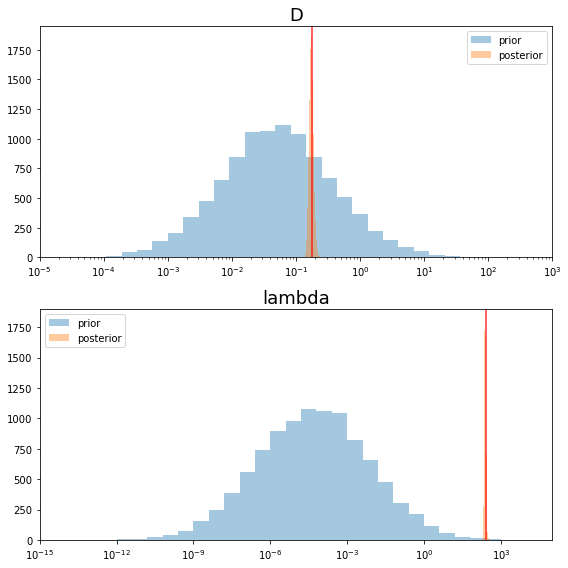

In [558]:
utils.plot_prior_posterior(param, trace1, [D_large, lambda_small])

#### Artifically reduce $t_{end}$ with the same number of data points 

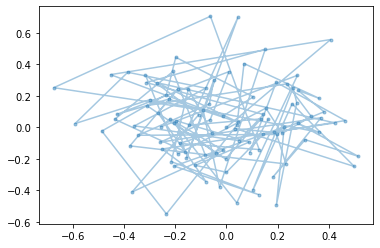

In [559]:
np.random.seed(5555)

init_pos = [0., 0.]
D_large = 0.175 # um^2/s
lambda_small = 250  #s^-1 
n_data = 101 

time_step1 = 0.08  # second/frame
time_step2 = 0.002  # second/frame
pixelToUm = 0.106  # um/pixel

t_ = np.linspace(0, time_step1*(n_data-1)/10, n_data) ####### NOTE HERE 
well_pos = [0., 0.]

simple_BD = [init_pos, t_, D_large, well_pos, lambda_small, None] 
traj = utils.generate_data(simple_BD) 

plt.plot(traj[0]/pixelToUm, traj[1]/pixelToUm, '.-', alpha=0.4)

D_scaled = D_large*time_step1/pixelToUm**2
lambda_scaled = lambda_small*time_step1 

sx, sy = traj 
sdt = np.diff(t_) 
sdx = np.diff(sx); sdy = np.diff(sy)

In [560]:
t_[:5], t_[-5:]

(array([0.   , 0.008, 0.016, 0.024, 0.032]),
 array([0.768, 0.776, 0.784, 0.792, 0.8  ]))

In [561]:
print('Note the shape of the dataset is of length {}.'.format(t_.shape[0]))

Note the shape of the dataset is of length 101.


In [562]:
with pm.Model() as model:
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lamda = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda']) 
   
    mean_x = (well_pos[0] - sx[:-1])*(1-tt.exp(-lamda*sdt))
    mean_y = (well_pos[1] - sy[:-1])*(1-tt.exp(-lamda*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*lamda*sdt))/lamda)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [563]:
with model: 
    trace1 = pm.sample(5000, tune=4000, chains=2, cores=1, target_accept=0.99) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, D]
Sampling chain 1, 0 divergences: 100%|██████████| 9000/9000 [00:28<00:00, 315.19it/s]
The number of effective samples is smaller than 25% for some parameters.


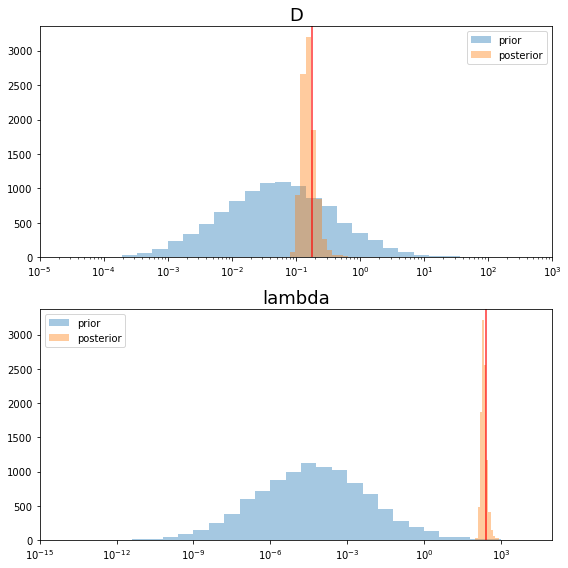

In [564]:
utils.plot_prior_posterior(param, trace1, [D_large, lambda_small])

## End posterior convergence section 

In [42]:
# constant timestep

corr_y = (sy-sy.mean())
corr_x = (sx-sx.mean())
n_times = len(sx) - 1

#######################################
# NOTE THIS LINE 
# me = 0.1  
cx = 0 
cy = 0 
####################################### 

def HPW_logp(data): # n_times is number of dts
    
    sigma0 = 10
    
    # main diag
    a = np.zeros(n_times+1)
    b = np.ones(n_times+1)
    b2 = np.zeros(n_times+1)
    a[0], b[0] = 1, 0
    b[-1], b2[-1] = 0, 1
    
    # off diag
    c = -np.ones(n_times)
    k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)
    
    Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                  np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                  (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  
    
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + tt.diag(np.ones((n_times+1, ))) * me**2
    Sigma_T = tt.nlinalg.matrix_inverse(Sigma)
    
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((cx-corr_x), Sigma_T), (cx-corr_x)) - \
           0.5*pm.math.dot(pm.math.dot((cy-corr_y), Sigma_T), (cy-corr_y)) 

    return logp

In [43]:
model2 = pm.Model()

with model2: 
    
    D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
    lam = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda'])
    me = pm.Lognormal('me', param['mu_Me'], param['sigma_Me']) ## me fixed in code above 
    
#     cx = pm.Uniform('cx', min(corr_x), max(corr_x))
#     cy = pm.Uniform('cy', min(corr_y), max(corr_y))
    
    like = pm.DensityDist('like', HPW_logp, observed=1)

In [44]:
with model2:
    trace = pm.sample(5000, tune=4000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (4 chains in 1 job)
NUTS: [me, lam, D]
Sampling chain 3, 8 divergences: 100%|██████████| 9000/9000 [00:46<00:00, 193.49it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/mnt/c/Users/Gauthier/L_Anaconda3_Envs/pymc3l/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/mnt/c/Users/Gauthier/L_Anaconda3_Envs/pymc3l/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/mnt/c/Users/Gauthier/L_Anaconda3_Envs/pymc3l/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/mnt/c/Users/Gauthier/L_Anaconda3_Envs/pymc3l/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38:

array([[<AxesSubplot:title={'center':'D'}>,
        <AxesSubplot:title={'center':'D'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>],
       [<AxesSubplot:title={'center':'me'}>,
        <AxesSubplot:title={'center':'me'}>]], dtype=object)

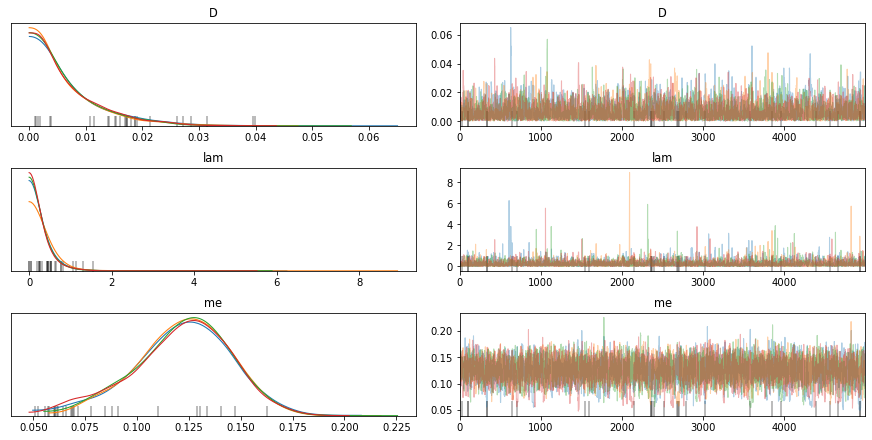

In [45]:
pm.traceplot(trace)

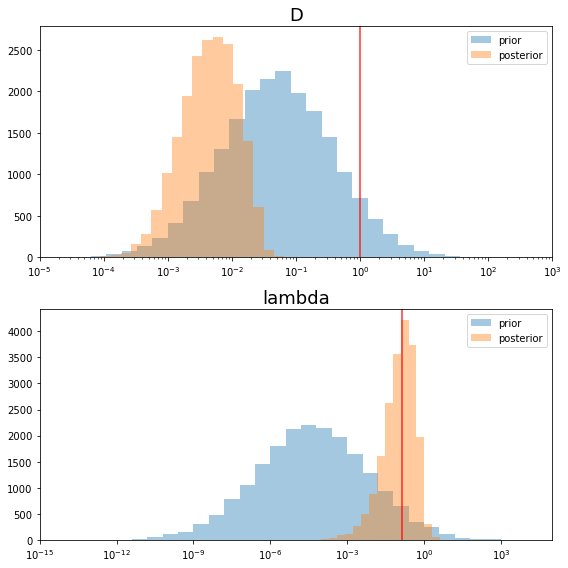

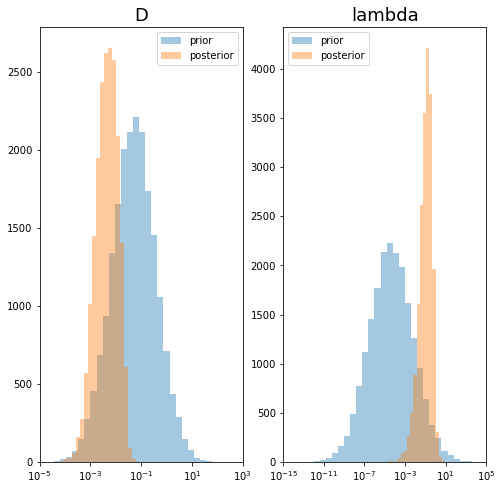

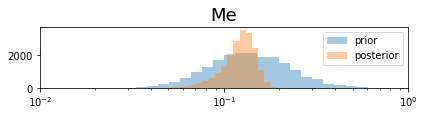

In [211]:
plt.figure(figsize=(8,8)) 
bins_D = np.logspace(param['mu_D'] - 3.*param['sigma_D'], param['mu_D'] + 3.*param['sigma_D'], 51) 
plt.subplot(121)
# plt.subplot(311) 

sns.distplot(pm.Lognormal.dist(param['mu_D'], param['sigma_D']).random(size=len(trace['D'])), 
             bins=bins_D, kde=False, label='prior') 
sns.distplot(trace['D'], bins=np.logspace(np.log10(min(trace['D'])), np.log10(max(trace['D'])), 21), 
             kde=False, label='posterior') 
# sns.distplot(pm.Lognormal.dist(param['mu_D'], param['sigma_D']).random(size=len(trace)), 
#              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
# sns.distplot(trace['D'], bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='posterior') 
plt.semilogx() 
plt.legend() 
plt.xlim(1e-5, 1e3)
plt.title('D', fontsize=18) 

bins_lam = np.logspace(param['mu_lambda'] - 1.*param['sigma_lambda'], param['mu_lambda'] + 5.*param['sigma_lambda'], 51)
plt.subplot(122)
# plt.subplot(312) 
sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace['lam'])), 
             bins=bins_lam, kde=False, label='prior') 
sns.distplot(trace['lam'], bins=np.logspace(np.log10(min(trace['lam'])), np.log10(max(trace['lam'])), 21), 
             kde=False, label='posterior') 
# sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace)), 
#              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
# sns.distplot(trace['lam'], bins=np.logspace(np.log(min(trace['lam'])), np.log(max(trace['lam'])), 51), 
#              kde=False, label='posterior') 
plt.semilogx() 
plt.legend() 
plt.xlim(1e-15, 1e5)
plt.title('lambda', fontsize=18) 
plt.show() 

try: 
    bins_Me = np.logspace(param['mu_Me'] - 1.*param['sigma_Me'], param['mu_Me'] + 5.*param['sigma_Me'], 51)
    plt.subplot(313) 
    sns.distplot(pm.Lognormal.dist(param['mu_Me'], param['sigma_Me']).random(size=len(trace['me'])), 
                 bins=bins_Me, kde=False, label='prior') 
    sns.distplot(trace['me'], bins=np.logspace(np.log10(min(trace['me'])), np.log10(max(trace['me'])), 21), 
                 kde=False, label='posterior') 
    # sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace)), 
    #              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
    # sns.distplot(trace['lam'], bins=np.logspace(np.log(min(trace['lam'])), np.log(max(trace['lam'])), 51), 
    #              kde=False, label='posterior') 
    plt.semilogx() 
    plt.legend() 
    plt.xlim(1e-2, 1e0)
    plt.title('Me', fontsize=18) 
except: 
    pass  

plt.tight_layout() 
pass 

In [192]:
min(trace['lam']), max(trace['lam'])

(5.188674409824182e-06, 8.926005469415973)

## Generating fake data 

We've got a couple things to do here, the first is to **recover $D$, $\lambda$ from noiseless data generated from an HPW model**, second, we must **generate data from both the BD population and HPW population**, third, we have to reproduce these results with either **fixed or sampled noise**, and fourth, we must test the edge cases which are 
1. small $D$, large $\lambda$ 
2. small $D$, large $M_e$ 
3. large $\lambda$, large $M_e$ 

In [97]:
def generate_data(dict_): 
    init_pos, t_, D, well_pos, lambda_, Me = dict_ 
    
    ## BD model 
    if lambda_ == None and well_pos == None: 
        traj = base_brownian_D(init_pos, t_, D)  
    
    ## HPW model 
    else: 
        traj = base_HPW_D(init_pos, t_, D, well_pos, lambda_) 
    
    ## add measurement noise 
    if Me == None: 
        pass 
    else: 
        traj = augment_with_noise(traj, Me=Me) 
        
    return traj 

#### convert this to a dictionary 

In [100]:
init_pos = [0., 0.]; t_ = np.linspace(0, 20, 21)

In [101]:
test_set = np.tile([init_pos, t_, 1., [0., 0.], np.exp(-6), None], (6,1)) 
test_set[0][2] = 0.2; test_set[0][4] = np.exp(-2) ## small D, large lambda 
test_set[1][2] = 0.2; test_set[1][5] = 1. ## small D, large Me 
test_set[2][4] = 0.2; test_set[2][5] = 1. ## large lambda, large Me 
test_set[3][2] = 3.0; test_set[3][4] = np.exp(-8) ## large D, small lambda 

In [102]:
sx_, sy_ = generate_data(test_set[0]) 

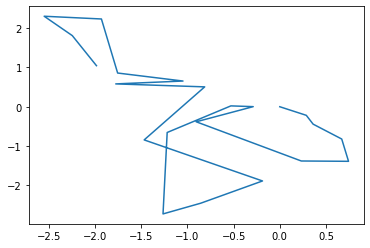

In [103]:
plt.plot(sx_, sy_)

In [104]:
# def HPW_logp(data): # n_times is number of dts 
def HPW_logp(n_times, lam, D, cx, corr_x, cy, corr_y, me): # n_times is number of dts
    
    sigma0 = 10
    
    # main diag
    a = np.zeros(n_times+1)
    b = np.ones(n_times+1)
    b2 = np.zeros(n_times+1)
    a[0], b[0] = 1, 0
    b[-1], b2[-1] = 0, 1
    
    # off diag
    c = -np.ones(n_times)
    k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)
    
    Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                  np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                  (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  
    
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + tt.diag(np.ones((n_times+1, ))) * me**2
    Sigma_T = tt.nlinalg.matrix_inverse(Sigma)
    
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((cx-corr_x), Sigma_T), (cx-corr_x)) - \
           0.5*pm.math.dot(pm.math.dot((cy-corr_y), Sigma_T), (cy-corr_y)) 

    return logp

In [105]:
def validate_test_set(test_set_row): 
    sx, sy = generate_data(test_set_row) 
    
    # constant timestep

    corr_y = (sy-sy.mean())
    corr_x = (sx-sx.mean()) 
    plt.plot(corr_x, corr_y) 
    n_times = len(sx) - 1

    #######################################
    # NOTE THIS LINE 
    me = 0   
    cx = 0 
    cy = 0 
    ####################################### 
    
    def HPW_logp(data): 
        
        sigma0 = 10

        # main diag
        a = np.zeros(n_times+1)
        b = np.ones(n_times+1)
        b2 = np.zeros(n_times+1)
        a[0], b[0] = 1, 0
        b[-1], b2[-1] = 0, 1

        # off diag
        c = -np.ones(n_times)
        k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)

        Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                      np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                      (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  

        Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + tt.diag(np.ones((n_times+1, ))) * me**2
        Sigma_T = tt.nlinalg.matrix_inverse(Sigma)

        logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((cx-corr_x), Sigma_T), (cx-corr_x)) - \
               0.5*pm.math.dot(pm.math.dot((cy-corr_y), Sigma_T), (cy-corr_y)) 
        
        return logp
    
    model2 = pm.Model()
    with model2: 

        D = pm.Lognormal('D', param['mu_D'], param['sigma_D'])
        lam = pm.Lognormal('lam', param['mu_lambda'], param['sigma_lambda'])
#         me = pm.Lognormal('me', param['mu_Me'], param['sigma_Me']) ## me fixed in code above 

    #     cx = pm.Uniform('cx', min(corr_x), max(corr_x))
    #     cy = pm.Uniform('cy', min(corr_y), max(corr_y))

        like = pm.DensityDist('like', HPW_logp, observed=1) 
#         like = pm.Potential('like', HPW_logp(n_times, lam, D, cx, corr_x, cy, corr_y, me)) 
#         logp = HPW_logp(n_times, lam, D, cx, corr_x, cy, corr_y, me) 
#         like = pm.DensityDist('like', logp, observed=1) 
    with model2:
        trace = pm.sample(5000, tune=4000, chains=4, cores=1, init='jitter+adapt_diag')  
    
    return trace 

In [106]:
def plot_prior_posterior(param, trace, true_vals=None): 
    plt.figure(figsize=(10,8)) 
    bins_D = np.logspace(param['mu_D'] - 3.*param['sigma_D'], param['mu_D'] + 3.*param['sigma_D'], 51) 
    plt.subplot(311) 

    sns.distplot(pm.Lognormal.dist(param['mu_D'], param['sigma_D']).random(size=len(trace['D'])), 
                 bins=bins_D, kde=False, label='prior') 
    sns.distplot(trace['D'], bins=np.logspace(np.log10(min(trace['D'])), np.log10(max(trace['D'])), 21), 
                 kde=False, label='posterior') 
    # sns.distplot(pm.Lognormal.dist(param['mu_D'], param['sigma_D']).random(size=len(trace)), 
    #              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
    # sns.distplot(trace['D'], bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='posterior') 
    plt.semilogx() 
    plt.legend() 
    plt.title('D', fontsize=18) 
    if not true_vals == None: plt.axvline(true_vals[0], c='r', alpha=0.8) 

    bins_lam = np.logspace(param['mu_lambda'] - 1.*param['sigma_lambda'], param['mu_lambda'] + 5.*param['sigma_lambda'], 51)
    plt.subplot(312) 
    sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace['lam'])), 
                 bins=bins_lam, kde=False, label='prior') 
    sns.distplot(trace['lam'], bins=np.logspace(np.log10(min(trace['lam'])), np.log10(max(trace['lam'])), 21), 
                 kde=False, label='posterior') 
    # sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace)), 
    #              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
    # sns.distplot(trace['lam'], bins=np.logspace(np.log(min(trace['lam'])), np.log(max(trace['lam'])), 51), 
    #              kde=False, label='posterior') 
    plt.semilogx() 
    plt.legend() 
    plt.title('lambda', fontsize=18) 
    if not true_vals == None: plt.axvline(true_vals[1], c='r', alpha=0.8) 

    try: 
        bins_Me = np.logspace(param['mu_Me'] - 1.*param['sigma_Me'], param['mu_Me'] + 5.*param['sigma_Me'], 51)
        plt.subplot(313) 
        sns.distplot(pm.Lognormal.dist(param['mu_Me'], param['sigma_Me']).random(size=len(trace['me'])), 
                     bins=bins_Me, kde=False, label='prior') 
        sns.distplot(trace['me'], bins=np.logspace(np.log10(min(trace['me'])), np.log10(max(trace['me'])), 21), 
                     kde=False, label='posterior') 
        # sns.distplot(pm.Lognormal.dist(param['mu_lambda'], param['sigma_lambda']).random(size=len(trace)), 
        #              bins=np.logspace(np.log(min(trace['D'])), np.log(max(trace['D'])), 51), kde=False, label='prior') 
        # sns.distplot(trace['lam'], bins=np.logspace(np.log(min(trace['lam'])), np.log(max(trace['lam'])), 51), 
        #              kde=False, label='posterior') 
        plt.semilogx() 
        plt.legend() 
        plt.title('Me', fontsize=18) 
        if not true_vals == None and not true_vals[2] == None: plt.axvline(true_vals[2], c='r', alpha=0.8) 
    except: 
        pass  

    plt.tight_layout() 
    pass 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [lam, D]
Sampling chain 3, 1,868 divergences: 100%|██████████| 9000/9000 [00:17<00:00, 524.43it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.881301031046272, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5664108335709299, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6379945872407096, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4183 divergences after tuning. Increase `target_accept` or

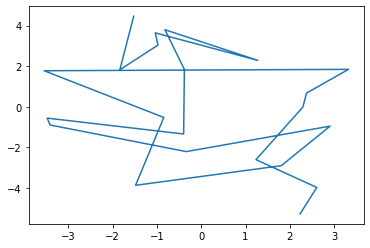

In [107]:
trace_ = validate_test_set(test_set[3]) 

## this is with me = 0 

In [108]:
test_set[3][4], 3e-4 

(0.00033546262790251185, 0.0003)

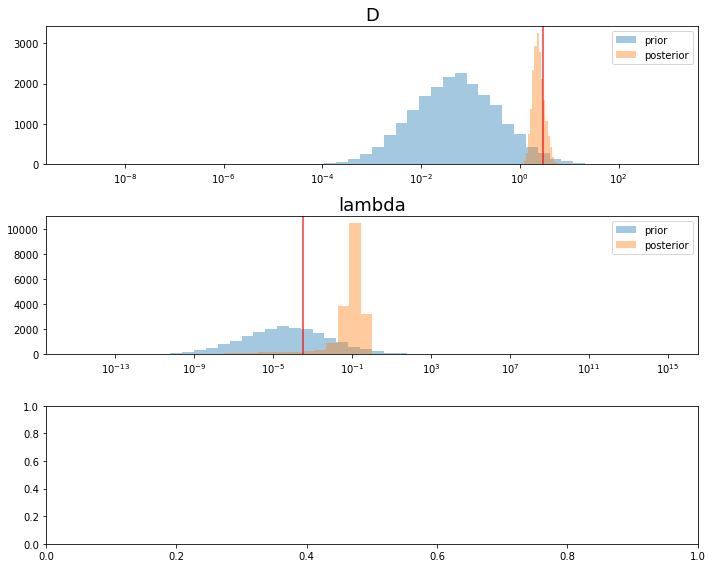

In [109]:
plot_prior_posterior(param, trace_, true_vals=[test_set[3][2], test_set[3][4], test_set[3][5]]) 

In [110]:
np.max(trace['lam']), np.min(trace['lam']), np.mean(trace['lam']), test_set[3][4]

(8.926005469415973,
 5.188674409824182e-06,
 0.22392362737124769,
 0.00033546262790251185)

In [111]:
test_set[5][2], test_set[5][4], test_set[5][5]

(1.0, 0.0024787521766663585, None)

## Lognormal priors 

The mean of a lognormal distribution is $\exp(\mu + \frac{1}{2} \sigma^2)$, and the variance is $\exp(2\mu+\sigma^2)(\exp(\sigma^2)-1)$ 

the mean is 1.65e+00 and the std is 2.16e+00


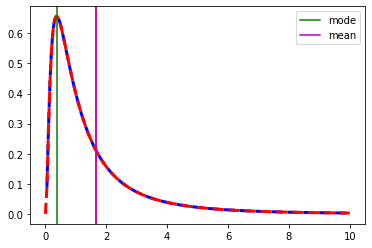

In [446]:
x_ = np.linspace(0, 10, 201) 
mu_ = 0 
sd_ = 1 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sd=sd_).logp(x_).eval()), c='b', ls='--', lw=3) 
plt.plot(x_, scipy.stats.lognorm(loc=mu_, s=sd_).pdf(x_), c='r', ls='--', lw=3) 
print('the mean is {:.2e} and the std is {:.2e}'.format(np.exp(mu_ + 0.5*sd_**2),\
                                                            np.sqrt(np.exp(2*mu_ + sd_**2)*(np.exp(sd_**2) - 1.))) )
plt.axvline(np.exp(mu_ + 0.5*sd_**2), c='r'); 
plt.axvline(0.367, c='g', label='mode') # mode 
plt.axvline(1.65, c='m', label='mean') # mean 
plt.legend(); 

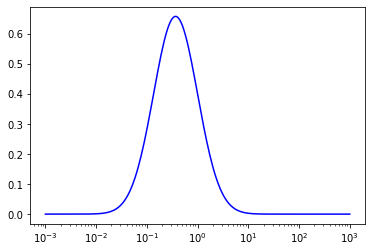

In [405]:
x_ = np.logspace(-3, 3, 201)
# x_ = np.linspace(1e-3, 1e3, 201) 
mu_ = 0 
sd_ = 1 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sd=sd_).logp(x_).eval()), c='b') 
plt.semilogx() 
pass 

the mean is 1.65e+00 and the std is 2.16e+00


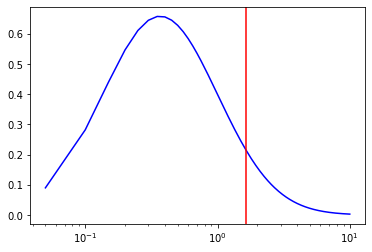

In [370]:
x_ = np.linspace(0, 10, 201) 
mu_ = 0 
sd_ = 1 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sd=sd_).logp(x_).eval()), c='b') 
plt.xscale('log')
print('the mean is {:.2e} and the std is {:.2e}'.format(np.exp(mu_ + 0.5*sd_**2),\
                                                            np.sqrt(np.exp(2*mu_ + sd_**2)*(np.exp(sd_**2) - 1.))) )
plt.axvline(np.exp(mu_ + 0.5*sd_**2), c='r'); 

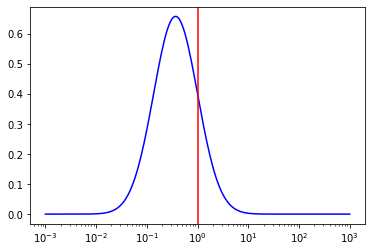

In [406]:
x_ = np.logspace(-3, 3, 201)  
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval()), c='b') 
# pm.Lognormal(mu=mu_, sd=sd_).random(1000)
plt.axvline(np.exp(mu_), c='r') 
plt.xscale('log')

[]

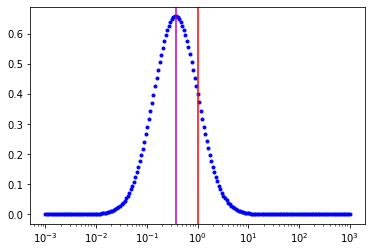

In [419]:
x_ = np.logspace(-3, 3, 201)  
for idx in range(len(x_)): 
    plt.plot(x_[idx], np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_[idx]).eval()), 'b.') 
    if idx == np.argmax(np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval())): 
        plt.axvline(x_[idx], c='m')
# plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval()), c='b') 
plt.axvline(np.exp(mu_), c='r') 
# plt.axvline(86, c='m')
# plt.xscale('log') 
plt.semilogx() 

In [422]:
def lognormal_manual(x, mu, sigma, log10=None): 
    if log10 == None or log10 == False: 
        return (np.sqrt(2*np.pi)*sigma*x)**(-1) * np.exp(-0.5*sigma**(-2) * (np.log(x) - mu) ** 2)
    else: 
        return (np.sqrt(2*np.pi)*sigma*x)**(-1) * np.exp(-0.5*sigma**(-2) * (np.log10()))

[]

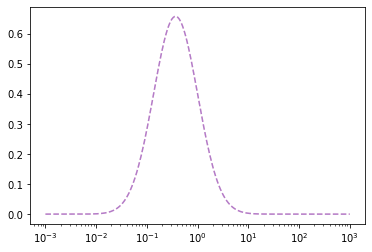

In [428]:
x_ = np.logspace(-3, 3, 201)  
plt.plot(x_, lognormal_manual(x_, mu_, sd_), c='r', ls='--', alpha=0.3) 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval()), c='b', ls='--', alpha=0.3) 
plt.semilogx() 

In [414]:
np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval())[np.argmax(np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval()))] 

0.6573884366070499

In [429]:
x_[np.argmax(np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval()))]

0.38018939632056126

In [430]:
np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(np.array([1.65])).eval())

array([0.21329016])

In [421]:
np.exp(mu_ + 0.5 * sd_ ** 2), np.exp(mu_)

(1.6487212707001282, 1.0)

In [418]:
np.argmax(np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval())) 

86

In [ ]:
np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_).logp(x_).eval())

In [ ]:
pm.Lognormal.dist(mu=mu_, sigma=sd_, transform=None).

## WHAT IS THE DIFFERENCE 

[]

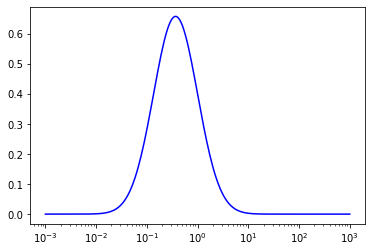

In [388]:
x_ = np.logspace(-3, 3, 201)  
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_, transform=None).logp(x_).eval()), c='b') 
# plt.hist(pm.Lognormal.dist(mu=mu_, sigma=sd_).random(size=50000), bins=np.logspace(-3, 3, 51)) 
plt.semilogx(base=10)

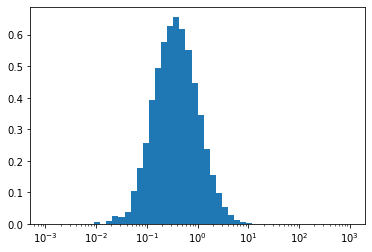

In [393]:
# x_ = np.logspace(-3, 3, 201)  
# plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mu_, sigma=sd_, transform=None).logp(x_).eval()), c='b') 
plt.semilogx() 
plt.hist(pm.Lognormal.dist(mu=mu_, sigma=sd_).random(size=50000), bins=np.logspace(-3, 3, 51), density=True) 
pass 

[]

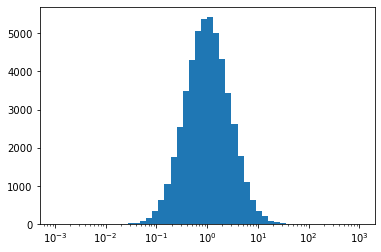

In [399]:
plt.hist(pm.Lognormal.dist(mu=mu_, sigma=sd_).random(size=50000), bins=np.logspace(-3, 3, 51)) 
plt.semilogx()

[]

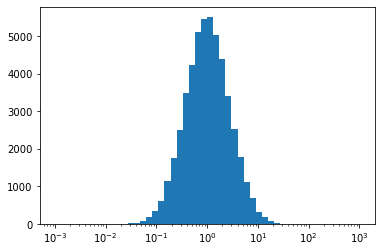

In [394]:
plt.hist(pm.Lognormal.dist(mu=mu_, sigma=sd_).random(size=50000), bins=np.logspace(-3, 3, 51)) 
plt.semilogx()

In [ ]:
# constant timestep

corr_y = (sy-sy.mean())
corr_x = (sx-sx.mean())
n_times = len(sx) - 1
def HPW_logp(data): # n_times is number of dts
    
    sigma0 = 10
    
    # main diag
    a = np.zeros(n_times+1)
    b = np.ones(n_times+1)
    b2 = np.zeros(n_times+1)
    a[0], b[0] = 1, 0
    b[-1], b2[-1] = 0, 1
    
    # off diag
    c = -np.ones(n_times)
    k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)
    
    Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                  np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                  (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  
    
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + tt.diag(np.ones((n_times+1, ))) * me**2
    Sigma_T = tt.nlinalg.matrix_inverse(Sigma)
    
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((cx-corr_x), Sigma_T), (cx-corr_x)) - \
           0.5*pm.math.dot(pm.math.dot((cy-corr_y), Sigma_T), (cy-corr_y)) 

    return logp

In [ ]:
model2 = pm.Model()

with model2: 
    
    D = pm.Lognormal('D', 0, 1)
    lam = pm.Lognormal('lam', 0, 1)
#     me = pm.Lognormal('me', 0, 1)
    
#     cx = pm.Uniform('cx', -0.2, 0.2)
#     cy = pm.Uniform('cy', -0.2, 0.2)
    
    like = pm.DensityDist('like', HPW_logp, observed=1)

# Think about your edge cases in terms of  $\lambda, D, M_e$ 

# STRONGLY consider your priors at this step 

# For each particle, run a full MCMC simulation for $\lambda, D$ 

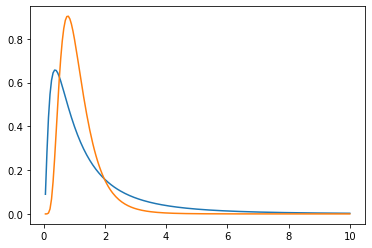

In [319]:
x_ = np.linspace(0, 10, 201) 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=0, sd=1).logp(x_).eval())) 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=0, sd=0.5).logp(x_).eval())) 
# plt.xlim(0, 0.5)

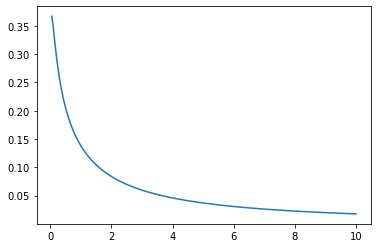

In [326]:
mu_ = 0. 
tau = 1. ## tau = 1/sigma**2 

mean_ = np.exp(mu_ + 1/(2*tau)) 
variance_ = (np.exp(1/tau) - 1.) * np.exp(2*mu_ + 1/tau) 
sd_ = np.sqrt(variance_) 
x_ = np.linspace(0, 10, 201) 
plt.plot(x_, np.exp(pm.Lognormal.dist(mu=mean_, sd=sd_).logp(x_).eval())) 

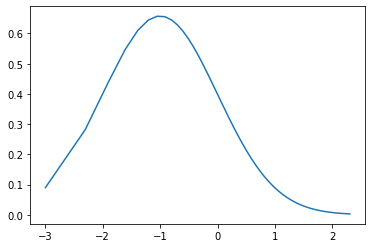

In [323]:
x_ = np.linspace(0, 10, 201) 
plt.plot(np.log(x_), np.exp(pm.Lognormal.dist(mu=0, sd=1).logp(x_).eval())) 
# plt.plot(np.log(x_), np.exp(pm.Lognormal.dist(mu=0, sd=0.5).logp(x_).eval())) 

### MCMC - Gaussian normal

In [53]:
model1 = pm.Model()

with model1: 
    D = pm.Lognormal('D', 0, 1)
    k = pm.Lognormal('k', 0, 1)
    
    c_x = pm.Uniform('c_x', lower=-0.2, upper=0.2)
    c_y = pm.Uniform('c_y', lower=-0.2, upper=0.2)
    
    mean_x = (c_x - (sx-sx.mean())[:-1]) * (1-tt.exp(-k*sdt))
    mean_y = (c_y - (sy-sy.mean())[:-1]) * (1-tt.exp(-k*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*k*sdt))/k)
    
    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [54]:
with model1:
    trace = pm.sample(2000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c_y, c_x, k, D]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 72 seconds.


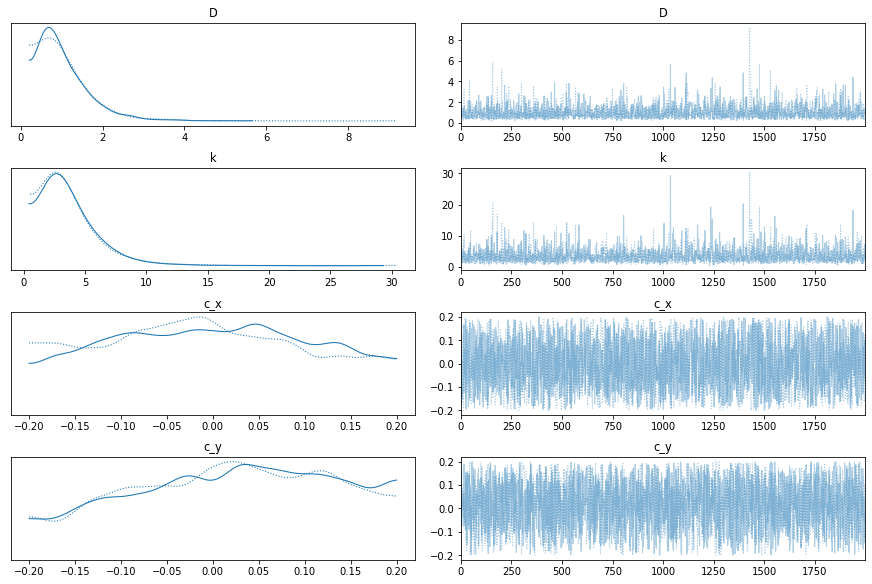

In [46]:
# minlen 10 track 76 nan lam
pm.traceplot(trace);

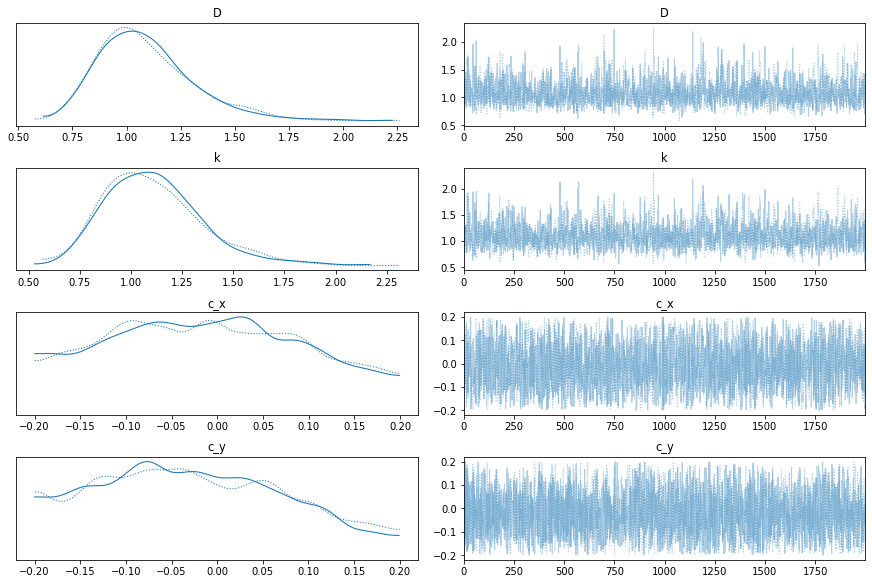

In [55]:
pm.traceplot(trace);

### MCMC - MvNormal

The idea is to turn the above guassion likelihood into MvNormal with mean vector containing cx and cy, and cov contains D and $\lambda$. Doing so we can easliy incorporate the measurement noise term by adding it to the diag terms of the cov.

In [127]:
# constant timestep

corr_y = (sy-sy.mean())
corr_x = (sx-sx.mean())
n_times = len(sx) - 1
def HPW_logp(data): # n_times is number of dts
    
    sigma0 = 10
    
    # main diag
    a = np.zeros(n_times+1)
    b = np.ones(n_times+1)
    b2 = np.zeros(n_times+1)
    a[0], b[0] = 1, 0
    b[-1], b2[-1] = 0, 1
    
    # off diag
    c = -np.ones(n_times)
    k = lam/D * (1/(1-tt.exp(-2*lam))) * tt.exp(-lam)
    
    Sigma_T = k * ((1/sigma0**2/k + 1) * np.diag(a, k=0) + \
                  np.diag(c, k=-1) + np.diag(c, k=1) + (1+tt.exp(-lam)) / \
                  (tt.exp(-lam)) * np.diag(b, k=0) + np.diag(b2, k=0) / (tt.exp(-lam)) )  
    
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + tt.diag(np.ones((n_times+1, ))) * me**2
    Sigma_T = tt.nlinalg.matrix_inverse(Sigma)
    
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*pm.math.dot(pm.math.dot((cx-corr_x), Sigma_T), (cx-corr_x)) - \
           0.5*pm.math.dot(pm.math.dot((cy-corr_y), Sigma_T), (cy-corr_y)) 

    return logp

In [7]:
model2 = pm.Model()

with model2: 
    
    D = pm.Lognormal('D', 0, 1)
    lam = pm.Lognormal('lam', 0, 1)
#     me = pm.Lognormal('me', 0, 1)
    
#     cx = pm.Uniform('cx', -0.2, 0.2)
#     cy = pm.Uniform('cy', -0.2, 0.2)
    
    like = pm.DensityDist('like', HPW_logp, observed=1)

In [8]:
with model2:
    trace = pm.sample(2000, tune=2000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
The number of effective samples is smaller than 25% for some parameters.


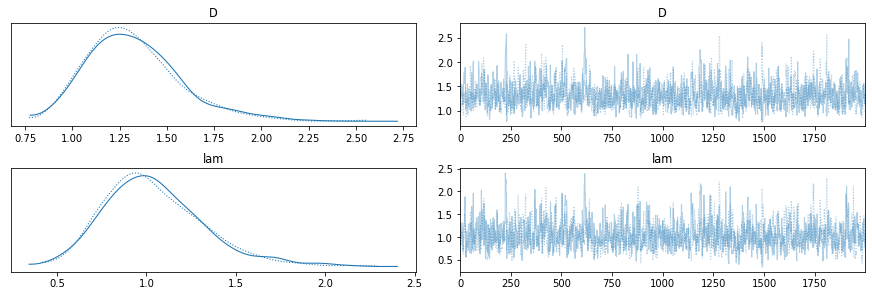

In [9]:
# log lam
pm.traceplot(trace);

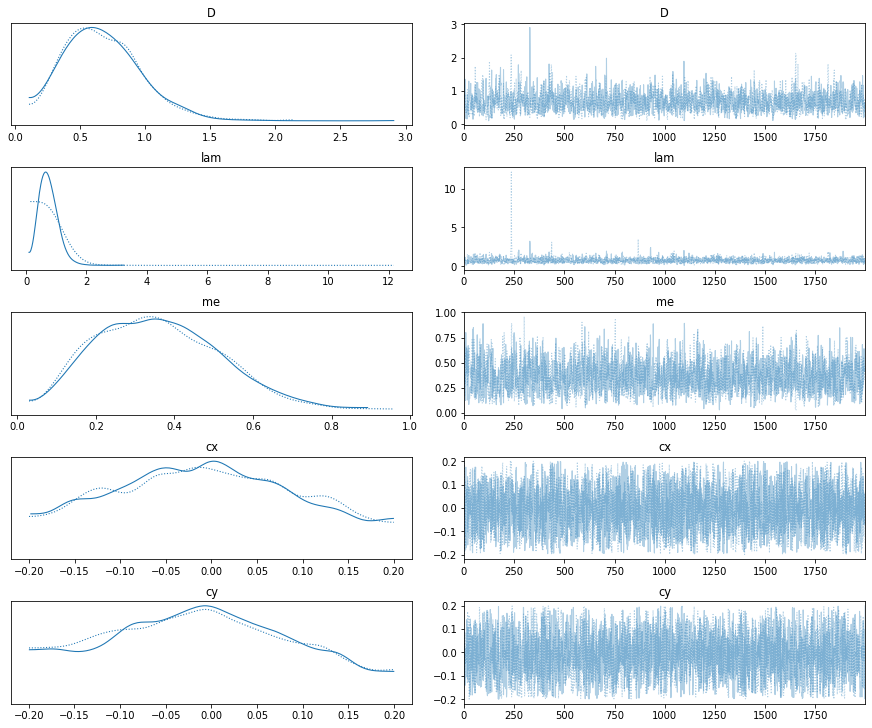

In [24]:
# log lam, log me, with uniform cx cy
pm.traceplot(trace);

In [27]:
trace['lam'].mean()

0.7432904772344074

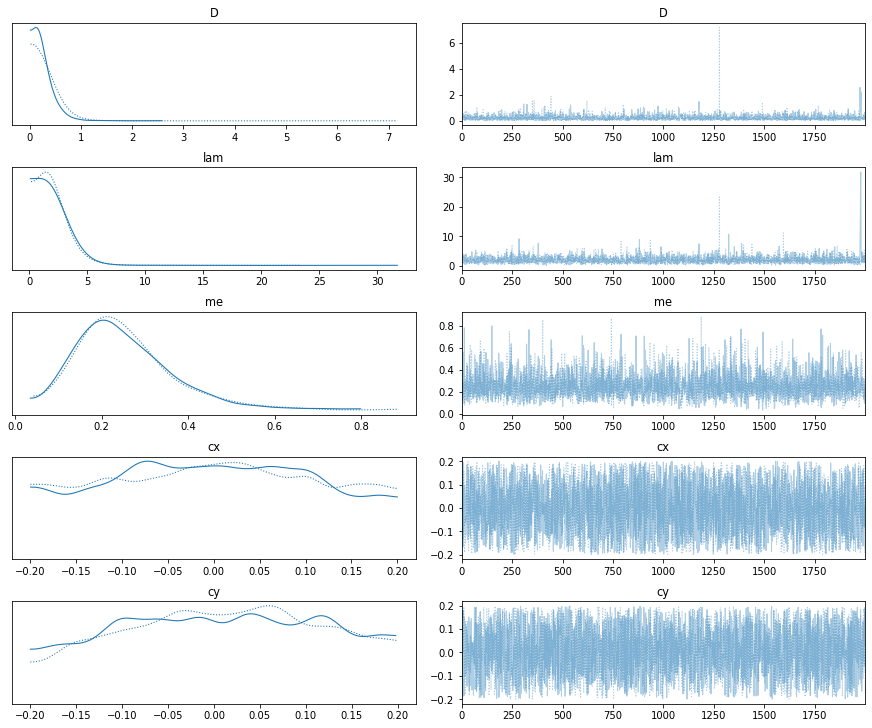

In [33]:
# log lam, log me, with uniform cx cy 
# minlen 10 track 76 which has nan lam
pm.traceplot(trace);

## Varying timestep

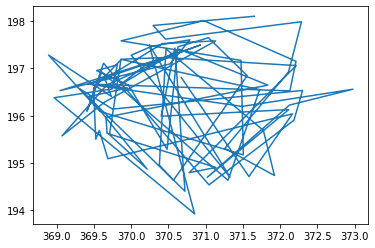

In [34]:
ind = 613
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, ind, False)
dt = st[1:] - st[:-1]
corr_y = (sy-sy.mean())
corr_x = (sx-sx.mean())
n_times = len(sx) - 1
plt.plot(sx, sy);

In [35]:
""" For varying time steps"""
def off_diag(lambda_, D, dt): 
    return -lambda_/D * (tt.exp(-lambda_*dt) / (1 - tt.exp(-2*lambda_*dt)))

def main_diag(lambda_, D, dt_, dt):  # dt is dt at k while dt_ is dt at k+1
    return lambda_/D * ((1)/(1 - tt.exp(-2*lambda_*dt)) + (tt.exp(-lambda_*dt_)/(1 - tt.exp(-2*lambda_*dt_))))

In [36]:
def pad_1(dt, dt_): 
    dt = np.insert(dt, 0, dt_[-1])
    dt = np.insert(dt, len(dt), dt_[-1])
    return dt

def pad_2(dt, dt_): 
    dt_ = np.insert(dt_, 0, dt[0])
    dt_ = np.insert(dt_, len(dt_), dt[0])
    return dt_

In [37]:
def HPW_logp_vt(data): # n_times is number of dts
    
    sigma0 = 10
                        
    # off-diag
    off_diag_ = off_diag(lambda_, D, dt)
    
    # main-diag
    main_diag1 = main_diag(lambda_, D, pad_1(dt[1:], dt[:-1]), pad_2(dt[1:], dt[:-1]))
    main_diag2, main_diag3 = np.zeros((n_times+1, )), np.zeros((n_times+1, ))
    main_diag2[0], main_diag3[-1] = 1, 1
    main_diag2_term = 1 / sigma0**2 - lambda_/D * (1 / (1 - tt.exp(-2*lambda_*dt[-1])))
    main_diag3_term = -lambda_/D * (tt.exp(-lambda_*dt[0])/(1 - tt.exp(-2*lambda_*dt[0])))
                                    
    Sigma_T = tt.diag(main_diag1, k=0) + main_diag2_term * tt.diag(main_diag2, k=0) + \
              main_diag3_term * tt.diag(main_diag3, k=0) + tt.diag(off_diag_, k=-1) + tt.diag(off_diag_, k=1)
    Sigma = tt.nlinalg.matrix_inverse(Sigma_T) + me**2 * tt.diag(np.ones((n_times+1, )))
    Sigma_T = tt.nlinalg.matrix_inverse(Sigma)
            
    logp = -tt.log(pm.math.det(Sigma)) - 0.5*tt.nlinalg.matrix_dot(corr_x, Sigma_T, corr_x) - \
           0.5*tt.nlinalg.matrix_dot(corr_y, Sigma_T, corr_y) 
    
    return logp          

In [38]:
model3 = pm.Model()

with model3: 
    
    D = pm.Lognormal('D', 0, 1)
    lambda_ = pm.Lognormal('lam', 0, 1)
    me = pm.Lognormal('me', 0, 1)
    
#     cx = pm.Uniform('cx', -0.2, 0.2)
#     cy = pm.Uniform('cy', -0.2, 0.2)
    
    like = pm.DensityDist('like', HPW_logp_vt, observed=1)

In [39]:
with model3:
    trace = pm.sample(2000, tune=2000, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [me, lam, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 310 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


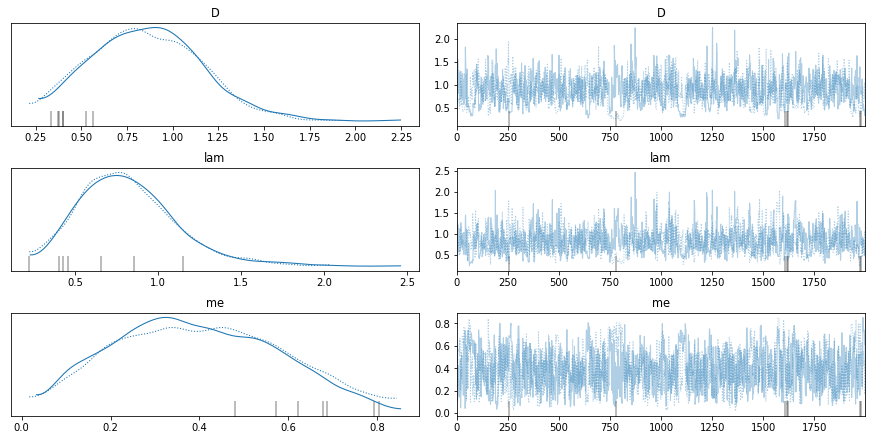

In [40]:
# 613
pm.traceplot(trace);

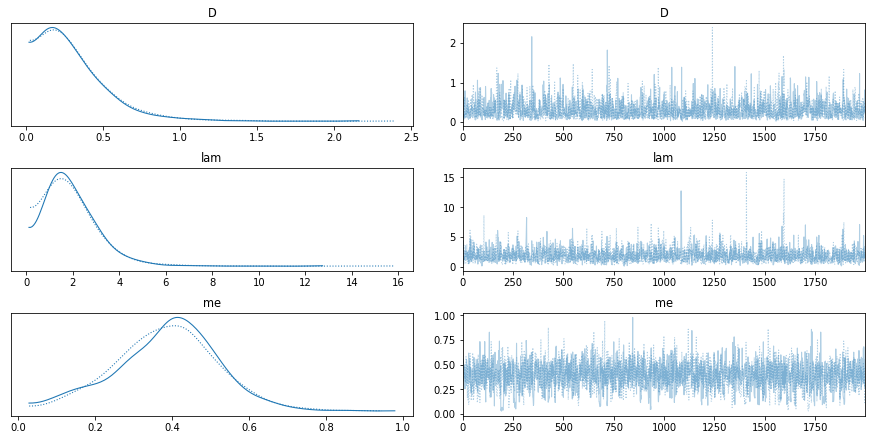

In [32]:
# 76
pm.traceplot(trace);